## Analyse models checkpoints for NLL of positives in the test set

In [1]:
import pandas as pd
import numpy as np
import torch
import pickle
import os
from tqdm.auto import tqdm

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score, f1_score, precision_score, recall_score, average_precision_score, balanced_accuracy_score

from rdkit import Chem
from rdkit.Chem import SaltRemover, RemoveStereochemistry
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger

import seaborn as sns
import matplotlib.pyplot as plt

import reinvent.models.reinvent.models.model as reinvent


In [2]:
# Disable rdkit logger
RDLogger.DisableLog('rdApp.*') 

In [3]:
%%bash
ls ../../data/test/

aggregators.npy
chembl.npy
fluc.csv
nluc.csv
redox.csv
thiol.csv


In [4]:
### DEFINE THE TASK
tasks = ["fluc", "nluc", "thiol", "redox"]

In [5]:
map_keys = {"fluc": "FI", "nluc": "NI", "redox": "RR", "thiol": "TR"}
map_acq = {"random":"Random", "greedy": "Greedy",  "epig": "EPIG", "greedyskill": "GreedySkill", "epigskill":"EPIGSkill"}

#### Load test data

In [6]:
def preprocess(smiles):
    salt_remover = SaltRemover.SaltRemover()
    smiles = smiles.replace("@", "")
    smiles = smiles.replace("/", "")
    if "I" in smiles:
        return None
    mol = Chem.MolFromSmiles(smiles)
    mol = salt_remover.StripMol(mol)

    return Chem.MolToSmiles(mol)

In [7]:
test_dict = {map_keys[i]: None for i in tasks}
for task in tasks:
    test_data = pd.read_csv(f"../../data/test/{task}.csv")
    # Collect positive and negative samples
    test_positives = test_data[test_data["label"] == 1]["smiles"].values.tolist()
    test_positives = [preprocess(smiles) for smiles in test_positives if preprocess(smiles) is not None]
    test_negatives = test_data[test_data["label"] == 0]["smiles"].values.tolist()
    test_negatives = [preprocess(smiles) for smiles in test_negatives if preprocess(smiles) is not None]
    test_dict[map_keys[task]] = {"positives": test_positives, "negatives": test_negatives}

#### Compute NNL for positive and negative examples

In [8]:
def retrieve_chkpt(acquisition, task, version, iteration):
    params = torch.load(f"../../FtF4/RUN_REINVENT/versions.history/v.chkpt/v{version}/{acquisition}/{task}/chkpt/{task}_{iteration}.chkpt")
    model = reinvent.Model.create_from_dict(
        save_dict=params, mode="inference", device=torch.device("cpu")
    )

    return model

In [9]:
def compute_likelihood(model, smiles):
    likelihood = []
    for i in smiles:
        try:
            likelihood.append(model.likelihood_smiles([i]).detach().numpy())
        except:
            continue
    return np.array(likelihood)

In [10]:
# Compute likelihoods for all models
likelihood_dict = {map_keys[i]: None for i in tasks}
for i in tasks:
    likelihood_positives = {map_acq[v]: [] for v in ["random", "greedy", "epig", "greedyskill", "epigskill"]}
    for j in ["random", "greedy", "epig", "greedyskill", "epigskill"]:
        for k in tqdm(range(1, 6)):
            for l in range(1, 11):
                model = retrieve_chkpt(j, i, k, l)
                likelihood = compute_likelihood(model, test_dict[map_keys[i]]["positives"]).mean()
                likelihood_positives[map_acq[j]].append(likelihood)
    likelihood_positives = pd.DataFrame(likelihood_positives)
    # Name index columns
    likelihood_positives["Iteration"] = np.array([[i for i in range(1, 11)] for _ in range(5)]).ravel()
    df_melted = pd.melt(likelihood_positives, id_vars="Iteration", var_name="Acquisition\nfunction", value_name="likelihood")
    likelihood_dict[map_keys[i]] = df_melted
    

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [11]:
palette = ["#808080", "#ee82ee", "#FFA500", "#7741f7", "#805380"]

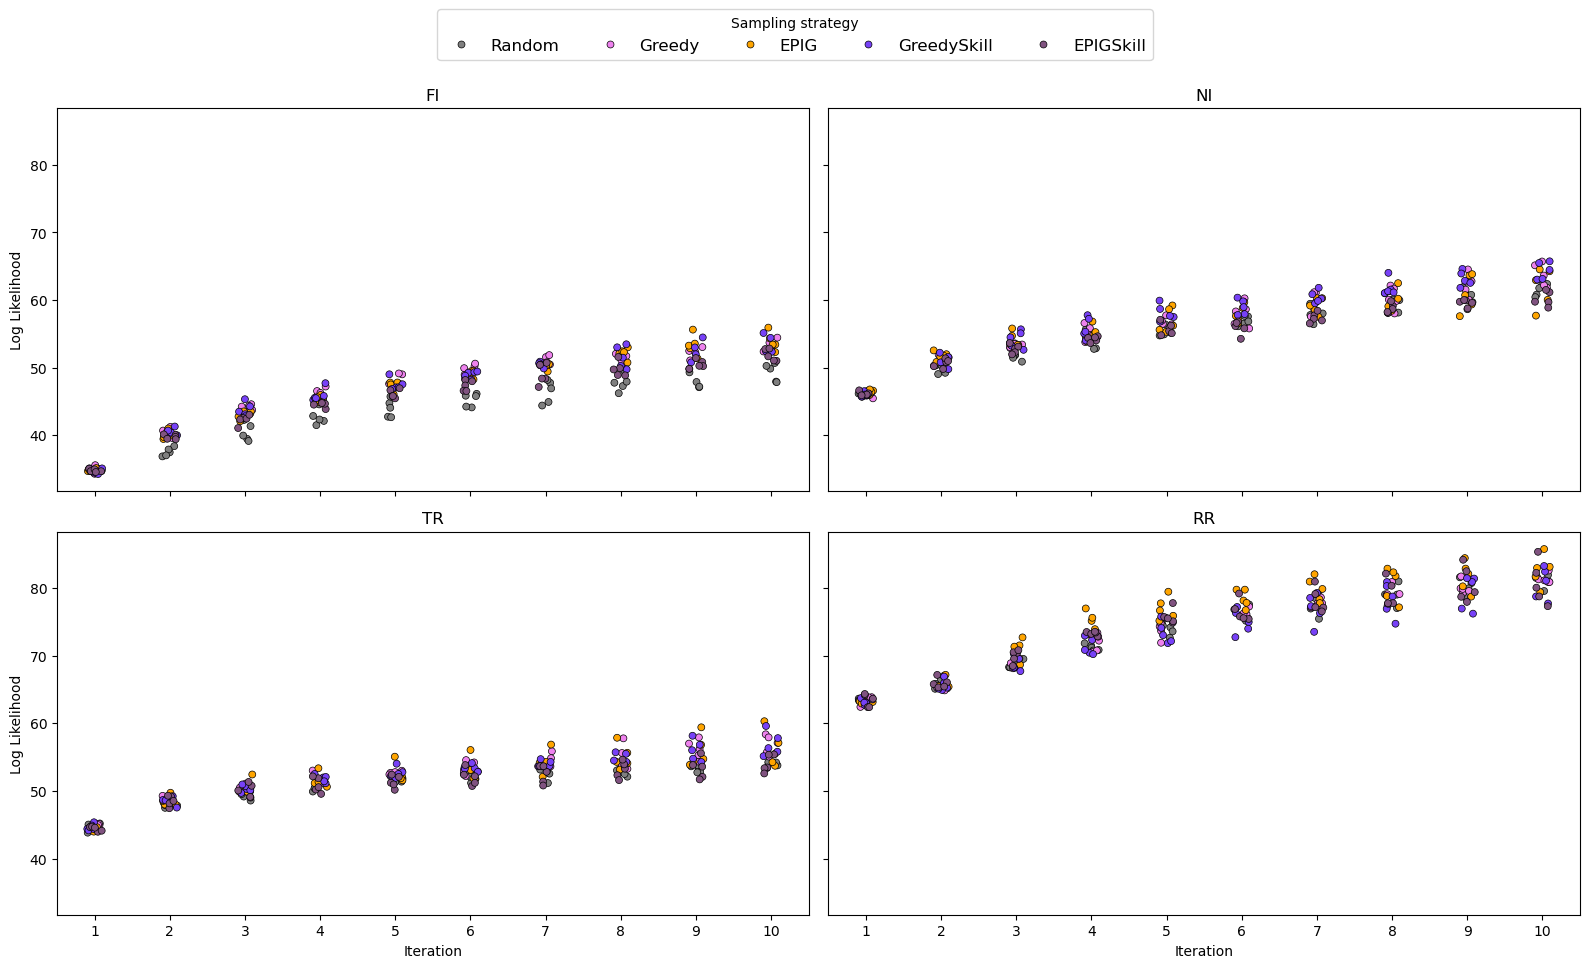

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(16, 9), sharey=True, sharex=True)
for i, (task, df) in enumerate(likelihood_dict.items()):
    x = int(i/2)
    y = i % 2
    sns.stripplot(data=df, x="Iteration", y="likelihood", hue="Acquisition\nfunction", edgecolor="k", linewidth=.5, jitter=True, ax=axes[x][y], palette=palette)
    # Plot horizontal line at teacher mean
    axes[x][y].set_title(f"{task}")
    axes[x][y].legend_.remove()
    axes[x][y].set_ylabel("Log Likelihood")
# Create shared legend
handles, labels = axes[0][0].get_legend_handles_labels()
legend = fig.legend(
    handles, 
    labels, 
    title="Sampling strategy", 
    bbox_to_anchor=(0.5, 1.08), 
    loc='upper center', 
    ncol=6, 
    fontsize=12,
)

for text in legend.get_texts():
    text.set_bbox(dict(facecolor='none', edgecolor='none'))  # Remove rectangle around label text

plt.tight_layout()
plt.show()